In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from constants import WEIGHT_CONSTRAINT, SECTOR, SECTOR_CONSTRAINT

from pypfopt.expected_returns import mean_historical_return, capm_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.plotting import plot_weights, plot_covariance

# pd.reset_option('display.float_format')
pd.options.display.float_format = lambda x: f'{x:.3f}'
plt.rcParams['font.family'] = 'Malgun Gothic'

In [144]:
def _sharpe_ratio_objective(weights, args):

    # 기대수익률
    expected_returns = args[0]

    # 공분산
    covariances = args[1]

    # Positive directional derivative for linesearch 이슈가 존재함.
    # 출처 : https://stackoverflow.com/questions/11155721/positive-directional-derivative-for-linesearch
    return -((weights.T@expected_returns) / (weights.T@covariances@weights)**0.5) / 1000000

In [145]:
def sector_lower_limits(x, sector_name):
    idx = np.where(np.array(list(SECTOR.values())) == sector_name)
    return np.sum(x[idx]) - SECTOR_CONSTRAINT[sector_name][0]/100

def sector_upper_limits(x, sector_name):
    idx = np.where(np.array(list(SECTOR.values())) == sector_name)
    return SECTOR_CONSTRAINT[sector_name][1]/100 - np.sum(x[idx])

lower_limits = [c[0]/100 for c in WEIGHT_CONSTRAINT.values()]
upper_limits = [c[1]/100 for c in WEIGHT_CONSTRAINT.values()]

In [146]:
def _get_mean_variance_weights(expected_returns, covariances, initial_weights):

    # 최적화 과정에서 고려해야 할 제약 조건을 다음과 같이 설정합니다.
    # 'eq': 등식(=0)을 의미함, 'ineq' : 부등식(≥0)을 의미합니다.
    constraints = ({'type': 'ineq', 'fun': lambda x: 1.0 - np.sum(x)},

                   # 각 상품군의 상하한선
                   {'type': 'ineq', 'fun': lambda x: np.array(upper_limits) - x},
                   {'type': 'ineq', 'fun': lambda x: x - np.array(lower_limits)},

                    # 각 자산군의 상한선
                   {'type': 'ineq', 'fun': lambda x: sector_upper_limits(x, "local_stock")},
                   {'type': 'ineq', 'fun': lambda x: sector_upper_limits(x, "foreign_stock")},
                   {'type': 'ineq', 'fun': lambda x: sector_upper_limits(x, "bond")},
                   {'type': 'ineq', 'fun': lambda x: sector_upper_limits(x, "commodity")},
                   {'type': 'ineq', 'fun': lambda x: sector_upper_limits(x, "inverse")},
                   {'type': 'ineq', 'fun': lambda x: sector_upper_limits(x, "fx")},
                   {'type': 'ineq', 'fun': lambda x: sector_upper_limits(x, "cash")},

                   # 각 자산군의 하한선
                   {'type': 'ineq', 'fun': lambda x: sector_lower_limits(x, "local_stock")},
                   {'type': 'ineq', 'fun': lambda x: sector_lower_limits(x, "foreign_stock")},
                   {'type': 'ineq', 'fun': lambda x: sector_lower_limits(x, "bond")},
                   {'type': 'ineq', 'fun': lambda x: sector_lower_limits(x, "commodity")},
                   {'type': 'ineq', 'fun': lambda x: sector_lower_limits(x, "inverse")},
                   {'type': 'ineq', 'fun': lambda x: sector_lower_limits(x, "fx")},
                   {'type': 'ineq', 'fun': lambda x: sector_lower_limits(x, "cash")},
                   )
                   
    # ftol(반복 계산 시 종료를 위한 허용치)은 작게 할수록,
    # maxiter는 크게 할수록 더 정확한 답을 찾으나 계샨량이 늘어납니다.          
    options = {'ftol': 1e-20, 'maxiter': 800}

    optimize_result = minimize(fun=_sharpe_ratio_objective,
                               x0=initial_weights, 
                               args=[expected_returns, covariances],
                               method='SLSQP',
                               constraints=constraints,
                               options=options)

    # 최적화 과정에서 나온 가중치 값 저장
    weights = optimize_result.x

    # 최적 자산 비중치 반환
    return weights, optimize_result

In [147]:
def get_weights_with_result():
    
    global prices

    # data 폴더에 있는 수정주가 데이터를 불러옵니다. 
    prices = pd.read_csv("./data/adjclose.csv", 
                         parse_dates=True, 
                         header=8, 
                         index_col='Name', 
                         skiprows=range(9, 14), 
                         thousands=',')       
    prices.index.name = 'date'
    prices = prices.astype(float)

    # 기대 수익률
    expected_returns = mean_historical_return(prices)
    
    covariances = CovarianceShrinkage(prices).ledoit_wolf().values

    # 초기 비중을 모두 동일하게 가져갑니다. 
    init_weights = [1 / prices.shape[1]] * prices.shape[1]

    weights, optimize_result = \
        _get_mean_variance_weights(expected_returns, covariances, init_weights)

    # 각 자산 비중을 판다스 시리즈 형태로 전환합니다.
    weights = pd.Series(weights, index=prices.columns, name='weight')

    # 최적의 비중을 반환합니다. 
    return weights, optimize_result

In [148]:
weights, optimize_result = get_weights_with_result()

In [149]:
optimize_result

     fun: -1.367359444735508e-06
     jac: array([ 9.65834190e-07,  3.06444190e-06,  7.09770418e-07,  2.70709397e-06,
        7.09770433e-07,  7.09770418e-07,  2.88521449e-07, -1.75276512e-07,
       -1.75276497e-07, -1.75276512e-07,  5.11699125e-06, -1.75276497e-07,
       -3.11971903e-07,  6.96886261e-07, -1.75276497e-07])
 message: 'Optimization terminated successfully'
    nfev: 4166
     nit: 226
    njev: 225
  status: 0
 success: True
       x: array([ 1.00000000e-01,  1.78870425e-21,  8.20796842e-02, -1.00576224e-21,
        6.73357935e-03,  1.11867365e-02, -1.59595757e-22,  1.91376299e-01,
        7.01137131e-02,  5.27195047e-02,  8.01765430e-23,  5.97226966e-02,
        2.00000000e-01,  4.65741104e-24,  2.26067787e-01])

<AxesSubplot:xlabel='Weight'>

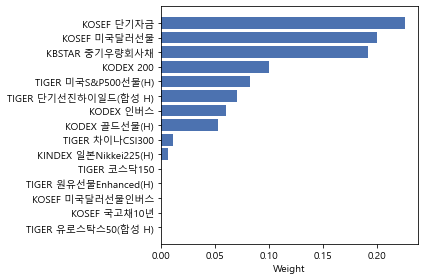

In [150]:
plot_weights(weights)

c:\Users\InBeom\.conda\envs\db_gaps\lib\site-packages\pypfopt\plotting.py:41: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()


<AxesSubplot:>

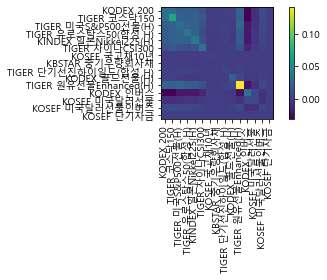

In [151]:
# prices.columns = [x for x in range(len(prices.columns))]
plot_covariance(CovarianceShrinkage(prices).ledoit_wolf())